# Simulateur de drone


Un drone quadriotor ou quadricoptère peut effectuer quatre mouvements:
<ul>
    <li> Les gaz : permettent d'effectuer une montée ou une descente en altitude </li>
    <li> Le lacet: permet au drone d'effectuer une rotation sur lui même dans le sens des aiguilles d'une montre ou dans le sens inverse </li>
    <li>  le rouli: permet au drone de se pencher sur un de ses axes pour effectuer une translation à gauche ou à droite  </li>
    <li>  le tangage : permet au drone de se pencher sur un de ses axes pour avancer ou reculer</li>
</ul>
    

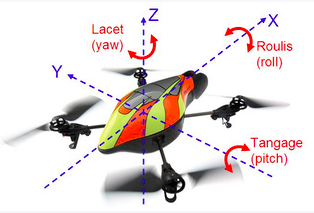

Tout ceci se traduit en 8 commandes de base : 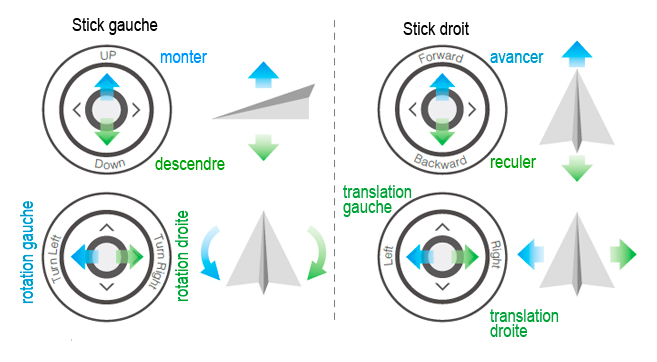
    

Il y a aussi biensur une commande décoller et une commande attérir. Lorsqu'on utilise un programme pour piloter le drone, il faudra à chaque fois préciser la vitesse et la durée lors de l'envoi des commandes.

## Paramétrage


soit OXYZ le repère orthonormé fixe lié au sol et AX'Y'Z' le repère orthonormé mobile lié au drone où A est le centre de gravité du drone.
Nous travaillons dans un répère cylindrique. Ainsi les directions OZ et OZ' coincident à tout moment.
Pour comprendre le paramètrage en terme d'angle, nous allons considérer un point B. Le drone (en A) est censé aller en B.
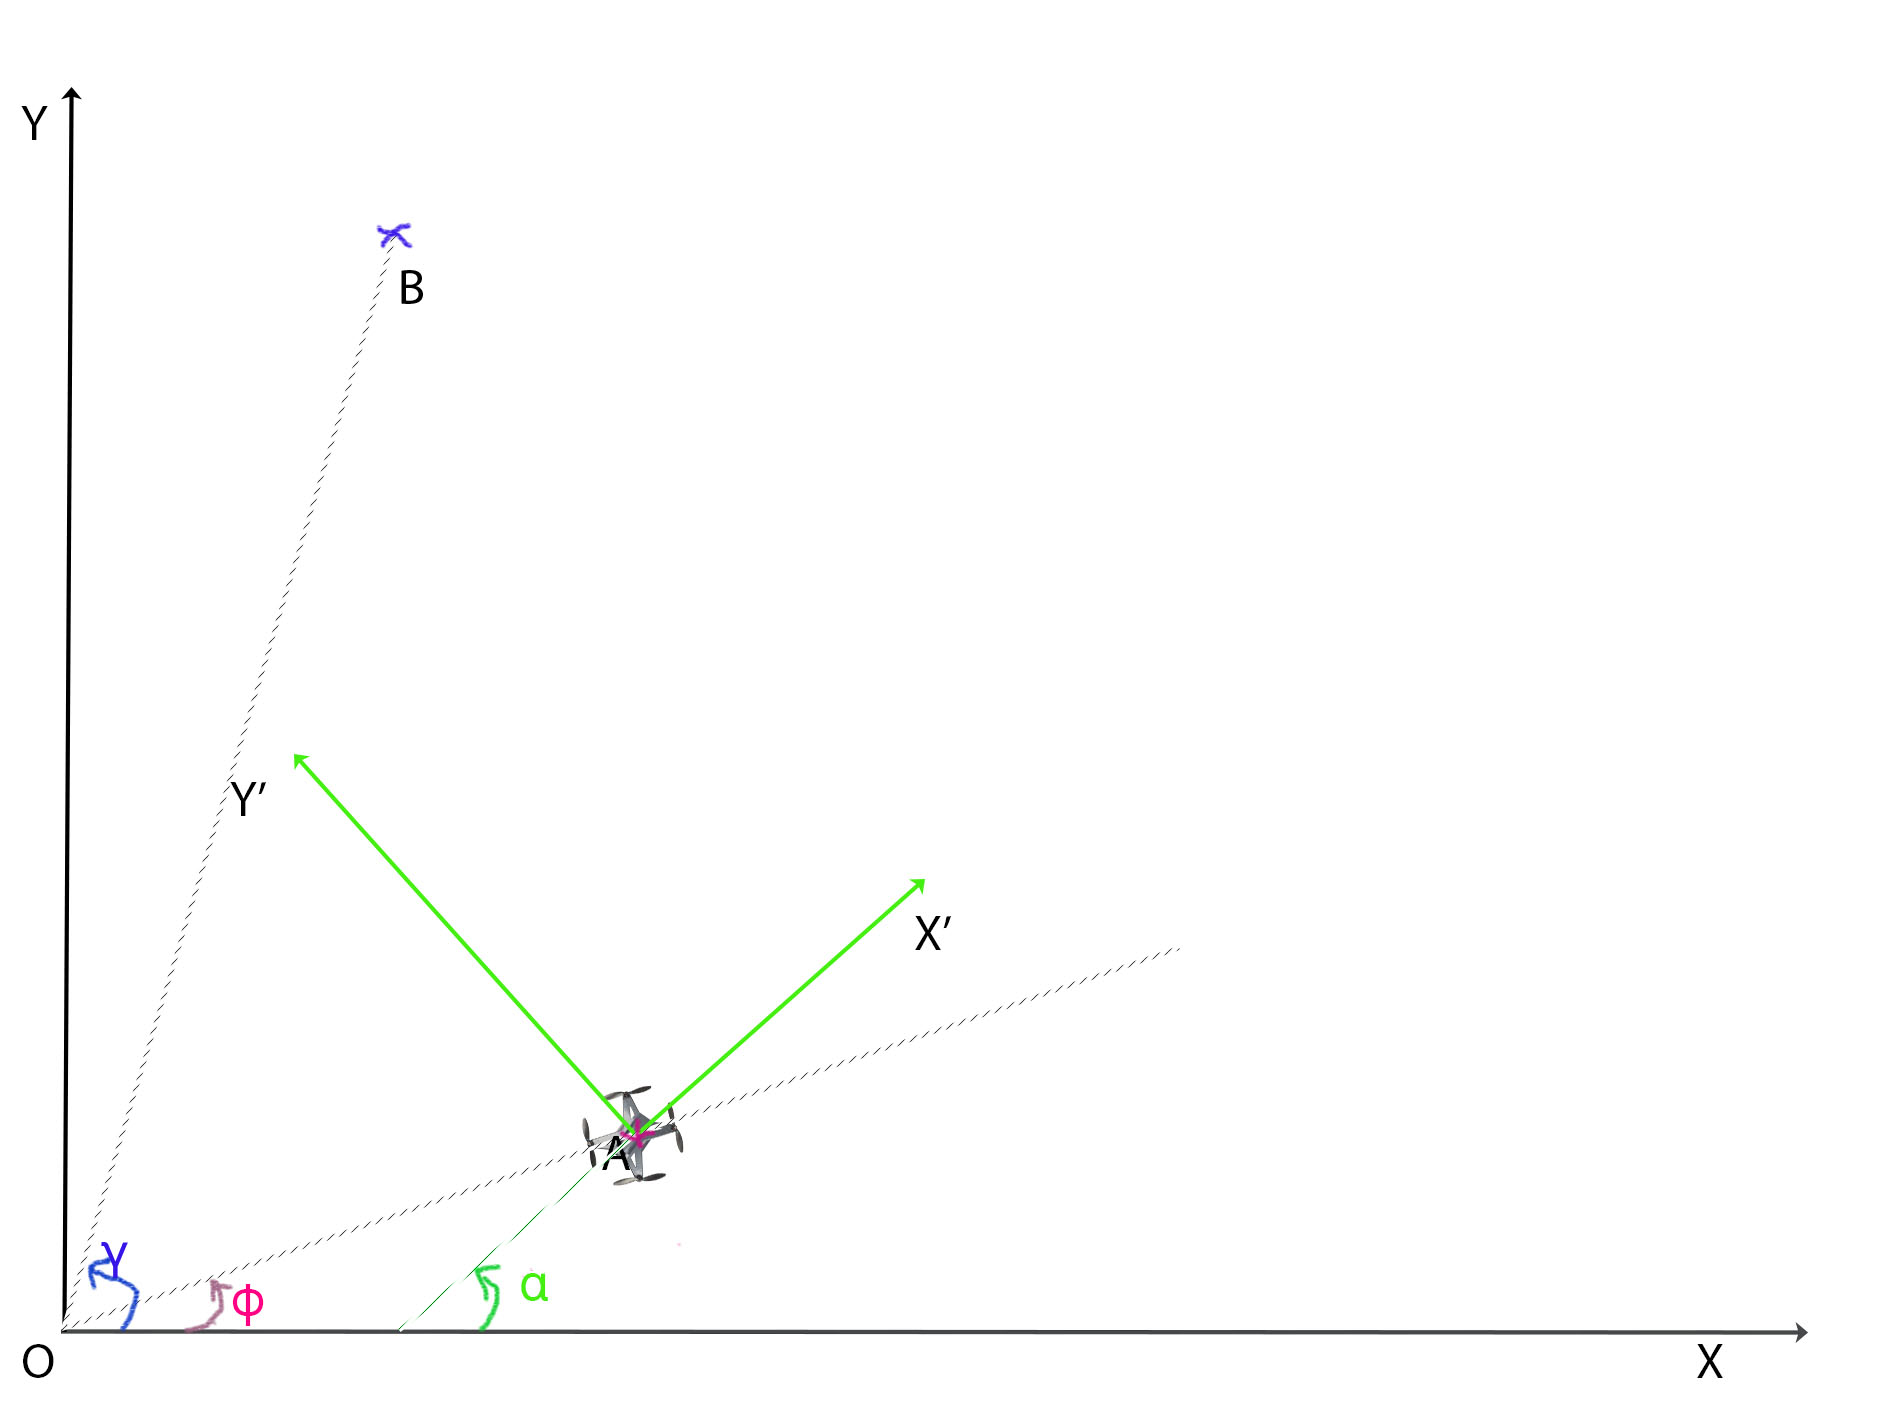
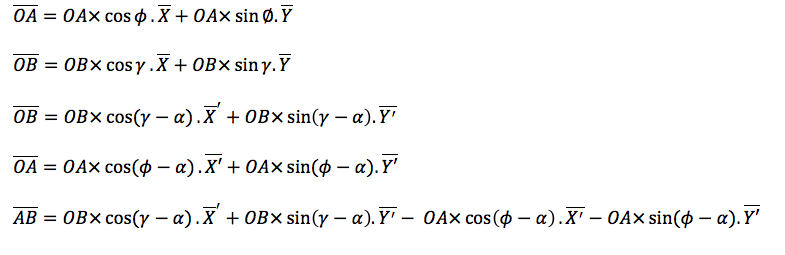

## Le modèle

Dans la suite, on va modéliser le drone par une classe objet avec des attributs de position et de vitesse maximale. Les commandes de base seront implémentées tout simplement par des méthodes qui mettront à jour la position du drone.

In [13]:
#-*- coding: utf-8 -*-
import math
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation


def distanceXY(point1, point2):
    """
    Distance des projections dans le plan XOY
    """
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def distance(point1, point2):
    """
    Distance dans l'espace
    """
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 +  (point1[2]-point2[2])**2)

def denivellation(point1, point2):
    """
    Différence de hauteur, c'est à dire distance des projections sur l'axe OZ
    """
    return point2[2]-point1[2]

class Drone():
    def __init__(self):
        """
        self.positionX/Y/Z := tableau qui enregistre l'historique des positions du drone comme avec un système de motion capture
        Ces tableaux seront utilisés pour animer un point simulant le drone dans l'espace.
        NB: l'unité de distance est le centimère et l'unité de temps est la seconde. En une seconde, nous prendrons 100 frames.
        """
        self.positionX = [0]
        self.positionY = [0]
        self.positionZ = [0]
        
        """
        les vitesses maximales de translation et de rotation ainsi que le pas minimal d'avancé sont pour le moment fixés arbitrairement!
        """
        self.maxSpeed = 100
        self.maxSpeedRotation = 2*math.pi/100 
        self.pasminimal=5
        
        """
        self.gonetoX/Y/Z := tableau qui enregistre les positions des extremites des petits segments décrits par le drone.
        Ces tableau seront plutot utilisé pour visualiser la trajectoire globale décrite par le drone.
        """
        self.goneToX = []
        self.goneToY = []
        self.goneToZ = []
        
        self.alpha = 0 # Dans un système de coordonées cylindrique, il s'agit de l'angle entre le repère du drone mobile et un repère fixe.
        self.fidelity = 0 #Il s'agit d'un compteur de points parcours par le drone dans le cas ou on imposera une suite de points à suivre
        
        self.planning = "" #chaine de caractère qui enregistre le planning de vol en termes de commandes
        
    def takeoff(self):
        """
        décoller
        """
        for i in range(100):#decollage en une seconde soit 100 frames
            self.positionZ += [self.positionZ[-1]+1] # Juste l'altitude est modifiée
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
        self.goneToX += [self.positionX[-1]]
        self.goneToY += [self.positionY[-1]]
        self.goneToZ += [self.positionZ[-1]]

    def land(self):
        """
        attérir
        """
        speed=0.8
        speedUsed=speed*self.maxSpeed
        duration = int(abs(self.positionZ[-1])/speedUsed*10000)/10000
        for i in range (int(duration*100)): #la durée étant en seconde nous aurons le produit par 100 pour les frames
            self.positionZ += [self.positionZ[-1] - speedUsed/100]# Juste l'altitude est modifiée
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.stop(); \n this.land(); \n });"

    def up(self, speed, duration):
        """
        Monter
        """
        speedUsed = speed * self.maxSpeed #speed est un reel entre 0 et 1 qui précise le pourcentage de vitesse à utiliser
        for i in range (int(duration*100)): #la durée étant en seconde nous aurons le produit par 100 pour les frames
            self.positionZ += [self.positionZ[-1] + speedUsed/100]# Juste l'altitude est modifiée
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.up("+str(speed)+"); \n }) \n "

    def down(self, speed, duration):
        """
        Descendre
        """
        print("duration dor down", duration)
        speedUsed = speed * self.maxSpeed
        for i in range(duration * 100):
            self.positionZ += [self.positionZ[-1] - speedUsed / 100]# Juste l'altitude est modifiée
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
            if self.positionZ[-1] < 0: self.positionZ[-1] = 0  # 0 correspond on sol, on peut pas descendre plus bas
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.down("+str(speed)+"); \n }) \n "
        
    def clockwise(self, speed, duration):
        """
        Rotation droite
        """
        print("doing clockwise")
        speedUsed = speed * self.maxSpeedRotation
        print("duration clockwise", duration)
        for i in range(int(duration * 100)):
            self.positionZ += [self.positionZ[-1]]
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
            self.alpha -= speedUsed/100            #il y a juste mise à jour de l'angle. Le sens horaire est négatif.
        print("alpha set to", self.alpha)
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.clockwise("+str(speed)+"); \n }) \n "

    def counterClockwise(self, speed, duration):
        """
        Rotation gauche
        """
        print("doing counterclockwise")
        speedUsed = speed * self.maxSpeedRotation
        for i in range(int(duration * 100)):
            self.positionZ += [self.positionZ[-1]]
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1]]
            self.alpha += speedUsed / 100        #il y a juste mise à jour de l'angle. Le sens horaire est négatif.
        print("alpha set to", self.alpha)
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.counterClockwise("+str(speed)+"); \n }) \n "

    def front(self, speed, duration):
        """
        Avancer 
        """
        print("doing front")
        speedUsed = speed * self.maxSpeed
        for i in range(int(duration * 10000)):
            #il faut bien garder en tete que le drone avance suivant son repère relatif propre (qui est mobile)
            #D'ou une modification suivant les axes X et Y en fonction de l'angle alpha
            self.positionX += [self.positionX[-1] + speedUsed*math.cos(self.alpha) / 10000]
            self.positionY += [self.positionY[-1] + speedUsed*math.sin(self.alpha) / 10000]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speed)+"); \n }) \n "

    def back(self, speed, duration):
        """
        reculer 
        """
        speedUsed = speed * self.maxSpeed
        for i in range(duration * 100):
            #il faut bien garder en tete que le drone avance suivant son repère relatif propre (qui est mobile)
            #D'ou une modification suivant les axes X et Y en fonction de l'angle alpha
            self.positionX += [self.positionX[-1] - speedUsed*math.cos(self.alpha) / 100]
            self.positionY += [self.positionY[-1] - speedUsed*math.sin(self.alpha) / 100]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.back("+str(speed)+"); \n }) \n "

    def left(self, speed, duration):
        """
        translation gauche 
        """
        speedUsed = speed * self.maxSpeed
        for i in range(duration * 100):
            #il faut bien garder en tete que le drone avance suivant son repère relatif propre (qui est mobile)
            #D'ou une modification suivant les axes X et Y en fonction de l'angle alpha
            self.positionX += [self.positionX[-1] - speedUsed*math.sin(self.alpha) / 100]
            self.positionY += [self.positionY[-1] + speedUsed*math.cos(self.alpha) / 100]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.left("+str(speed)+"); \n }) \n "

    def right(self, speed, duration):
        """
        translation droite 
        """
        speedUsed = speed * self.maxSpeed
        for i in range(duration * 100):
            #il faut bien garder en tete que le drone avance suivant son repère relatif propre (qui est mobile)
            #D'ou une modification suivant les axes X et Y en fonction de l'angle alpha
            self.positionX += [self.positionX[-1] + speedUsed*math.sin(self.alpha) / 100]
            self.positionY += [self.positionY[-1] - speedUsed*math.cos(self.alpha) / 100]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.right("+str(speed)+"); \n }) \n "

    def frontClockwise(self, speedFront, speedClockwise, duration):
        """
        avancer + tourner à droite 
        """
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedClockwise = speedClockwise * self.maxSpeedRotation
        for i in range(duration * 100):
            self.alpha -= speedUsedClockwise / 100
            self.positionX += [self.positionX[-1] + speedUsedFront * math.cos(self.alpha) / 100]
            self.positionY += [self.positionY[-1] + speedUsedFront * math.sin(self.alpha) / 100]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+"); \n this.clockwise("+str(speedClockwise)+"); \n }) \n "

    def frontCounterClockwise(self, speedFront, speedCounterClockwise, duration):
        """
        avancer + tourner à gauche 
        """
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedCounterClockwise = speedCounterClockwise * self.maxSpeedRotation
    
        for i in range(duration * 100):
            self.alpha += speedUsedCounterClockwise / 100
            self.positionX += [self.positionX[-1] + speedUsedFront * math.cos(self.alpha) / 100]
            self.positionY += [self.positionY[-1] + speedUsedFront * math.sin(self.alpha) / 100]
            self.positionZ += [self.positionZ[-1]]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+"); \n this.counterClockwise("+str(speedCounterClockwise)+"); \n }) \n "

    def frontUp(self,speedUp,rate,niveau):
        """
        avancer + monter
        """
        print('doing frontup')
        speedUsedUp = speedUp * self.maxSpeed
        speedUsedFront = speedUsedUp*rate #rate=distance dans le XY divisé par la hauteur
        print("speedup", speedUsedUp)
        print('speedfront', speedUsedFront)
        duration = int(10000*niveau/math.sqrt(speedUsedUp**2 + speedUsedFront**2))/10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] + speedUsedFront * math.cos(self.alpha) / 10000.]
            self.positionY += [self.positionY[-1] + speedUsedFront * math.sin(self.alpha) / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedUp*rate)+"); \n this.up("+str(speedUp)+"); \n }) \n "

    def frontDown(self,speedDown,rate,niveau):
        """
        avancer + descendre 
        """
        print('doing frontdown')
        speedUsedDown = speedDown * self.maxSpeed
        speedUsedFront = speedUsedDown*rate #rate=distance XY/hauteur
        duration = int(-10000*niveau/math.sqrt(speedUsedDown**2 + speedUsedFront**2))/10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] - speedUsedFront * math.cos(self.alpha) / 10000.]
            self.positionY += [self.positionY[-1] - speedUsedFront * math.sin(self.alpha) / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedDown*rate)+"); \n this.up("+str(speedDown)+"); \n }) \n "
            
    def leftUp(self,speedLeft, rapportyz, duration):
        """
        translation gauche + monter
        """
        print('doing leftUp')
        speedUsedLeft = speedLeft*self.maxSpeed
        speedUsedUp = speedUsedLeft*rapportyz
        duration = int(10000 * duration / speedUsedLeft) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]  
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.left("+str(speedLeft)+"); \n this.up("+str(speedLeft*rapportyz)+"); \n }) \n "
        
    def leftDown(self,speedLeft, rapportyz, duration):
        """
        translation gauche + descendre
        """
        print('doing leftDown')
        speedUsedLeft = speedLeft*self.maxSpeed
        speedUsedDown = speedUsedLeft*rapportyz
        duration = int(10000 * duration / speedUsedLeft) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.] 
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.left("+str(speedLeft)+"); \n this.down("+str(speedLeft*rapportyz)+"); \n }) \n "


        
    def rightUp(self,speedRight, rapportyz, duration):
        """
        translation droite + monter
        """
        print('doing rightUp')
        speedUsedRight = speedRight*self.maxSpeed
        speedUsedUp = speedUsedRight*rapportyz
        duration = int(10000 * duration / speedUsedRight) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1] - speedUsedRight  / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]  
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.right("+str(speedRight)+"); \n this.up("+str(speedRight*rapportyz)+"); \n }) \n "


            
    def rightDown(self,speedRight, rapportyz, duration):
        """
        translation droite + descendre
        """
        print('doing rightdown')
        speedUsedRight = speedRight*self.maxSpeed
        speedUsedBack = speedUsedRight*rapportyz
        duration = int(10000 * duration / speedUsedRight) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1]]
            self.positionY += [self.positionY[-1] - speedUsedRight  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedBack/10000.] 
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.right("+str(speedRight)+"); \n this.down("+str(speedRight*rapportyz)+"); \n }) \n "

        
    def frontLeftUp(self,speedFront, rapportyx, rapportzx, duration):
        """
        avancer + translation gauche + monter
        """
        print('doing frontLeftUp')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedLeft = speedUsedFront*rapportyx
        speedUsedUp = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] + speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+");\n this.left("+str(speedFront*rapportyx)+"); \n this.up("+str(speedFront*rapportzx)+"); \n }) \n "


    def BackLeftUp(self,speedFront, rapportyx, rapportzx, duration):
        """
        reculer + translation gauche + monter
        """
        print('doing BackLeftUp')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedLeft = speedUsedFront*rapportyx
        speedUsedUp = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] - speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.back("+str(speedFront)+");\n this.left("+str(speedFront*rapportyx)+"); \n this.up("+str(speedFront*rapportzx)+"); \n }) \n "

            
    def frontLeftDown(self,speedFront, rapportyx, rapportzx, duration):
        """
        avancer + translation gauche + descendre
        """
        print('doing frontLeftDown')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedLeft = speedUsedFront*rapportyx
        speedUsedDown = speedUsedFront*rapportzx
        duration = int(100000 * duration / speedUsedFront) / 100000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] + speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+");\n this.left("+str(speedFront*rapportyx)+"); \n this.down("+str(speedFront*rapportzx)+"); \n }) \n "



    def BackLeftDown(self,speedFront, rapportyx, rapportzx, duration):
        """
        reculer + translation gauche + descendre
        """
        print('doing BackLeftDown')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedLeft = speedUsedFront*rapportyx
        speedUsedDown = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] - speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] + speedUsedLeft  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.back("+str(speedFront)+");\n this.left("+str(speedFront*rapportyx)+"); \n this.down("+str(speedFront*rapportzx)+"); \n }) \n "



    def frontRightUp(self,speedFront, rapportyx, rapportzx, duration):
        """
        avancer + translation droite + monter
        """
        print('doing frontRightUp')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedRight = speedUsedFront*rapportyx
        speedUsedUp = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] + speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] - speedUsedRight  / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+");\n this.right("+str(speedFront*rapportyx)+"); \n this.up("+str(speedFront*rapportzx)+"); \n }) \n "


            
    def BackRightUp(self, speedFront, rapportyx, rapportzx, duration):
        """
        reculer + translation droite + monter
        """
        print('doing BackRightUp')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedRight = speedUsedFront * rapportyx
        speedUsedUp = speedUsedFront * rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] - speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] - speedUsedRight / 10000.]
            self.positionZ += [self.positionZ[-1] + speedUsedUp / 10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.back("+str(speedFront)+");\n this.right("+str(speedFront*rapportyx)+"); \n this.up("+str(speedFront*rapportzx)+"); \n }) \n "



    def frontRightDown(self,speedFront, rapportyx, rapportzx, duration):
        """
        avancer + translation droite + descendre
        """
        print('doing frontRightDown')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedRight = speedUsedFront*rapportyx
        speedUsedDown = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] + speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] - speedUsedRight  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.front("+str(speedFront)+");\n this.right("+str(speedFront*rapportyx)+"); \n this.down("+str(speedFront*rapportzx)+"); \n }) \n "



    def BackRightDown(self,speedFront, rapportyx, rapportzx, duration):
        """
        reculer + translation droite + descendre
        """
        print('doing BackRightDown')
        speedUsedFront = speedFront * self.maxSpeed
        speedUsedRight = speedUsedFront*rapportyx
        speedUsedDown = speedUsedFront*rapportzx
        duration = int(10000 * duration / speedUsedFront) / 10000.
        print("duration", duration)
        for i in range(int(duration * 10000)):
            self.positionX += [self.positionX[-1] - speedUsedFront / 10000.]
            self.positionY += [self.positionY[-1] - speedUsedRight  / 10000.]
            self.positionZ += [self.positionZ[-1] - speedUsedDown/10000.]
        self.planning+= ".after("+ str(duration*1000)+ ", function() { \n this.back("+str(speedFront)+");\n this.right("+str(speedFront*rapportyx)+"); \n this.down("+str(speedFront*rapportzx)+"); \n }) \n "



    def goToPoint(self,point, pas):
        """
        Planification du parcours point par point en mode "avion". En fait le drone se tourne toujours vers son point cible 
        avant d'avancer vers celui ci.
        """
        point1 = [self.positionX[-1], self.positionY[-1], self.positionZ[-1]] #position actuelle du drone
        if distanceXY(point, point1) >= pas and denivellation(point,point1)**2 >= pas:
            print("going to point")
            theta = math.atan2(point[1],point[0]) #angle du point à atteindre
            phi = math.atan2(point1[1], point1[0]) #angle absolu du drone en tant que point
            print("theta",theta)
            #angle := angle relatif selon lequel le drone doit se tourner pour faire face au point cible
            angle = math.atan2(distanceXY(point,[0,0])*math.sin(theta-self.alpha)-distanceXY(point1,[0,0])*math.sin(phi-self.alpha), distanceXY(point,[0,0])*math.cos(theta-self.alpha)-distanceXY(point1,[0,0])*math.cos(phi-self.alpha))
            print("angle", angle)
            print(int((angle/self.maxSpeedRotation)*10000)/10000.0)
            if angle < 0:
                self.clockwise(1,int(-(angle/self.maxSpeedRotation)*10000)/10000.0)

            else :
                self.counterClockwise(1,int((angle/self.maxSpeedRotation)*10000)/10000.0)
            if denivellation(point1,point)==0:
                rate=0
            else:
                rate = distanceXY(point1, point)/denivellation(point1, point) 
            print("rate",rate)
            niveau = denivellation(point1, point)
            if rate > 0:
                self.frontUp(1,rate, niveau)
            elif rate< 0:
                self.frontDown(1, rate, niveau)
            else:
                self.front(1, int(((distanceXY(point1, point) /self.maxSpeed)*10000)/10000.0))
            self.fidelity += 1
            
        else: 
            print("skipping point")
        self.goneToX += [self.positionX[-1]]
        self.goneToY += [self.positionY[-1]]
        self.goneToZ += [self.positionZ[-1]]

    def goToPoint1(self, point, pas):
        """
        Planificateur de parcours point à point en utilisant uniquement des translations et pas de rotation.
        """
        point1 = [self.positionX[-1], self.positionY[-1], self.positionZ[-1]]
        if distance(point1,point) > pas:
            if (point[0]-point1[0]) > 0.2 or (point[0]-point1[0]) < -0.2:
                print("going to point")
                rapportyx= (point[1]-point1[1])/(point[0]-point1[0])
                rapportzx = (point[2] - point1[2]) / (point[0] - point1[0])
        

                if (point[0]-point1[0])> 0:
                    if (point[1]-point1[1])>0:
                        if (point[2] - point1[2]) >0:
                            self.frontLeftUp(1, rapportyx, rapportzx, (point[0]-point1[0]) )
                        else:
                            self.frontLeftDown(1, rapportyx, -rapportzx, (point[0] - point1[0]))
                    else:
                        if (point[2] - point1[2]) >0:
                            self.frontRightUp(1, -rapportyx, rapportzx, (point[0]-point1[0]) )
                        else:
                            self.frontRightDown(1, -rapportyx, -rapportzx, (point[0] - point1[0]))
                else:
                    if (point[1]-point1[1])>0:
                        if (point[2] - point1[2]) >0:
                            self.BackLeftUp(1, -rapportyx, -rapportzx, -(point[0]-point1[0]) )
                        else:
                            self.BackLeftDown(1, rapportyx, rapportzx, -(point[0] - point1[0]))
                    else:
                        if (point[2] - point1[2]) >0:
                            self.BackRightUp(1, rapportyx, -rapportzx, -(point[0]-point1[0]) )
                        else:
                            self.BackRightDown(1, rapportyx, rapportzx, -(point[0] - point1[0]))
            else:
                if (point[1]-point1[1])>0:
                    if (point[2] - point1[2]) >0:
                        self.leftUp(1, (point[2] - point1[2]) / (point[1] - point1[1]), (point[1]-point1[1]) )
                    else:
                        self.leftDown(1,-(point[2] - point1[2]) / (point[1] - point1[1]), (point[1] - point1[1]))
                elif (point[1]-point1[1])<0:
                    if (point[2] - point1[2]) >0:
                        self.rightUp(1, -(point[2] - point1[2]) / (point[1] - point1[1]), -(point[1]-point1[1]) )
                    else:
                        self.rightDown(1, (point[2] - point1[2]) / (point[1] - point1[1]), -(point[1] - point1[1]))
                else:
                    if (point[2] - point1[2]) >0:
                        self.up(1, int((((point[2] - point1[2])/self.maxSpeed)*10000)/10000.0))
                    else:
                        self.down(1, -int((((point[2] - point1[2])/self.maxSpeed)*10000)/10000.0))

            self.fidelity += 1
        else:
            print("skipping point")
        self.goneToX += [self.positionX[-1]]
        self.goneToY += [self.positionY[-1]]
        self.goneToZ += [self.positionZ[-1]]

### Module d'affichage

In [2]:
#-*- coding: utf-8 -*-
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np


def tracerTrajectoire(X,Y,Z,X1,Y1,Z1):
    fig1 = plt.figure(1)
    ax = fig1.gca(projection='3d')

    trajectoire2, = ax.plot(X, Y, Z ,'-' ,color="red", label='trajectoire du drone')
    trajectoireTheorique, = ax.plot(X1, Y1, Z1, 'o', label='points a atteindre theorique')
    trajectoire3, = ax.plot(X, Y, Z ,'x' ,label='trajectoire du drone')


    #ax.set_xlim([100, 1000])
    #ax.set_ylim([100, 1000])
    #ax.set_zlim([100, 1000])
    ax.set_title('Trajectoires')
    ax.legend()
    plt.show()


# animation du mobile sur sa trajectoire
def update_point(n, X1 ,Y1 ,Z1 ,point, trajet):
    point.set_data(np.array([X1[n], Y1[n]]))
    point.set_3d_properties(Z1[n], 'z')
    trajet.set_data(np.array([X1[:n], Y1[:n]]))
    trajet.set_3d_properties(Z1[:n], 'z')
    return point, trajet


def animerPoints(X, Y, Z):
    fig2 = plt.figure(2)
    ax = p3.Axes3D(fig2)

    mobile, = ax.plot([X[0]], [Y[0]], [Z[0]], 'x', label='drone')
    trajectoire, = ax.plot([X[0]], [Y[0]], [Z[0]], '-', color="red", label='trajectoire du drone')
    ani=animation.FuncAnimation(fig2, update_point, len(X), fargs=(X, Y, Z, mobile, trajectoire),interval=10, blit = False)

    ax.set_xlim3d([min(X), max(X)])
    ax.set_xlabel('X')
    ax.set_ylim3d([min(Y), max(Y)])
    ax.set_ylabel('Y')
    ax.set_zlim3d([min(Z), max(Z)])
    ax.set_zlabel('Z')
    ax.set_title('Animation drone')
    ax.legend()
    plt.show()


### Test du planificateur de vol en mode "avion"

going to point
('theta', 0.7853981633974483)
('angle', 0.7853981633974483)
12.4999
doing counterclockwise
('alpha set to', 0.7847698448667537)
('rate', 0.565685424949238)
doing frontup
('speedup', 100)
('speedfront', 56.568542494923804)
('duration', 2.1759)
going to point
('theta', 0.7853981633974483)
('angle', 0.001112422452760468)
0.0177
doing counterclockwise
('alpha set to', 0.7853981633974717)
('rate', 1.9385422142448199)
doing frontup
('speedup', 100)
('speedfront', 193.85422142448198)
('duration', 0.3778)
going to point
('theta', 0.8760580505981934)
('angle', 0.18195152647110105)
2.8958
doing counterclockwise
('alpha set to', 0.9669822187749697)
('rate', -2.598057252363034)
doing frontdown
('duration', 0.2707)
going to point
('theta', 0.9959701202336522)
('angle', 0.169046668560905)
2.6904
doing counterclockwise
('alpha set to', 1.1359999035380839)
('rate', -17.86668431784183)
doing frontdown
('duration', 0.0096)
going to point
('theta', 1.005266280178105)
('angle', -0.028994622

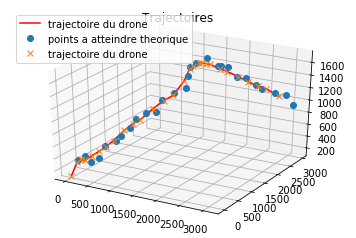

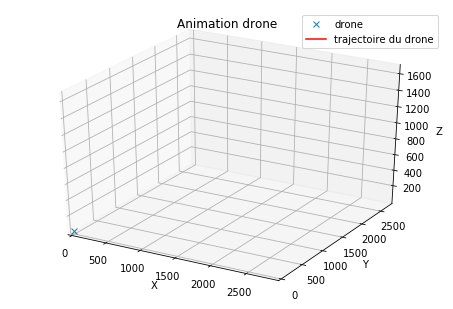

In [21]:

import random


X1=[100,200,250]
Y1=[100,200,300]
Z1=[350,400,280]


for i in range(15):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] + int(random.uniform(0,200))]
for i in range(10):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] - int(random.uniform(0,200))]




monDrone = Drone()
monDrone.takeoff()
pas=50

for i in range(len(X1)):
    monDrone.goToPoint([X1[i], Y1[i], Z1[i]], pas)

X = monDrone.goneToX
Y = monDrone.goneToY
Z = monDrone.goneToZ

X2 = [ monDrone.positionX[i] for i in range (1, len(monDrone.positionX), 1000)]
Y2 = [ monDrone.positionY[i] for i in range (1, len(monDrone.positionY), 1000)]
Z2 = [ monDrone.positionZ[i] for i in range (1, len(monDrone.positionZ), 1000)]
del monDrone

print(X1)
print(Y1)
print(Z1)
print(X)
print(Y)
print(Z)
print(Y2)


tracerTrajectoire(X,Y, Z, X1, Y1, Z1)
animerPoints(X2,Y2,Z2)




### Test du planificateur de vol en mode "translations only"

going to point
doing frontLeftUp
('duration', 1.0)
going to point
doing frontLeftUp
('duration', 0.9999)
going to point
doing frontLeftDown
('duration', 0.5001)
going to point
doing frontLeftUp
('duration', 1.02)
going to point
doing frontLeftUp
('duration', 0.72)
going to point
doing frontLeftUp
('duration', 0.54)
going to point
doing frontLeftUp
('duration', 1.06)
going to point
doing frontLeftUp
('duration', 1.43)
going to point
doing frontLeftUp
('duration', 0.04)
going to point
doing frontLeftUp
('duration', 0.03)
going to point
doing frontLeftUp
('duration', 0.17)
going to point
doing frontLeftUp
('duration', 1.03)
going to point
doing frontLeftUp
('duration', 0.73)
going to point
doing frontLeftUp
('duration', 0.35)
going to point
doing frontLeftUp
('duration', 1.87)
going to point
doing frontLeftUp
('duration', 0.6)
going to point
doing frontLeftUp
('duration', 0.83)
going to point
doing frontLeftUp
('duration', 0.05)
going to point
doing frontLeftDown
('duration', 1.42)
going 

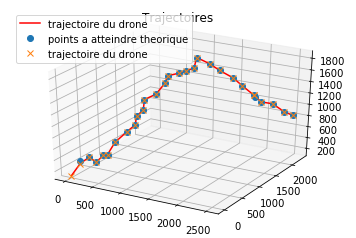

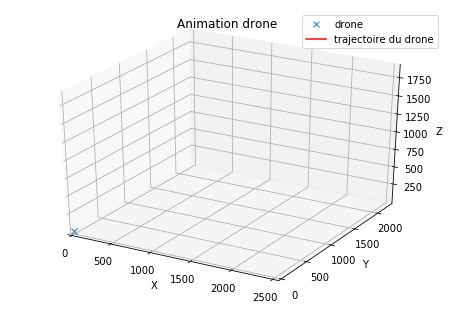

In [10]:

import random


X1=[100,200,250]
Y1=[100,200,300]
Z1=[350,400,280]


for i in range(15):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] + int(random.uniform(0,200))]
for i in range(10):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] - int(random.uniform(0,200))]




monDrone = Drone()
monDrone.takeoff()
pas=50

for i in range(len(X1)):
    monDrone.goToPoint1([X1[i], Y1[i], Z1[i]], pas)

X = monDrone.goneToX
Y = monDrone.goneToY
Z = monDrone.goneToZ

X2 = [ monDrone.positionX[i] for i in range (1, len(monDrone.positionX), 1000)]
Y2 = [ monDrone.positionY[i] for i in range (1, len(monDrone.positionY), 1000)]
Z2 = [ monDrone.positionZ[i] for i in range (1, len(monDrone.positionZ), 1000)]
del monDrone

print(X1)
print(Y1)
print(Z1)
print(X)
print(Y)
print(Z)
print(Y2)


tracerTrajectoire(X,Y, Z, X1, Y1, Z1)
animerPoints(X2,Y2,Z2)



## Estimation de l'erreur

On peut estimer en calculant la distance entre les points de la trajectoire théorique et les points de la trajectoire réelle du drone. Même dans l’hypothèse où le drone parcourait tous les points de la trajectoire théorique imposées, la trajectoire du drone enregistré avec la mocap paraitra continu (densité de points élevée). Il faudra alors, re-échantillonner la trajectoire réelle du drone de façon à obtenir un même nombre de points que celui de la trajectoire théorique.

L'erreur reste quasiment nulle si la trajectoire théorique est un polygone dont les sommets sont sufisaments espacés.

#### Re-échantillonage des trajecoires pour avoir un meme nombre de points

In [17]:
import math

def distance(point1, point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 +  (point1[2]-point2[2])**2)


def alignerEchantillon(pointsTheoriques, pointsMesures) :
    nouvelleSuite=[[],[],[]]
    erreurs = []
    d=0
    s = distance([pointsMesures[0][0], pointsMesures[1][0], pointsMesures[2][0]],
                 [pointsTheoriques[0][d], pointsTheoriques[1][d], pointsTheoriques[2][d]])
    i=1
    while i < len(pointsMesures[0]) and d < len(pointsTheoriques[0]):

        m=distance([pointsMesures[0][i],pointsMesures[1][i], pointsMesures[2][i]], [pointsTheoriques[0][d], pointsTheoriques[1][d], pointsTheoriques[2][d]])
        if m>=s :
            nouvelleSuite[0]+= [pointsMesures[0][i]]
            nouvelleSuite[1]+= [pointsMesures[1][i]]
            nouvelleSuite[2]+= [pointsMesures[2][i]]
            erreurs += [s]
            d+=1
            if d==len(pointsTheoriques[0]): break
            s = distance([pointsMesures[0][i], pointsMesures[1][i], pointsMesures[2][i]],
                         [pointsTheoriques[0][d], pointsTheoriques[1][d], pointsTheoriques[2][d]])
        else:
            s=m
        i+=1
    return nouvelleSuite, erreurs


#### Test 1

going to point
doing frontLeftUp
('duration', 1.0)
skipping point
going to point
doing frontLeftDown
('duration', 1.49999)
going to point
doing frontLeftUp
('duration', 0.5201)
skipping point
skipping point
going to point
doing frontLeftUp
('duration', 1.67)
going to point
doing frontLeftUp
('duration', 1.91)
going to point
doing frontLeftUp
('duration', 1.08)
skipping point
going to point
doing frontLeftUp
('duration', 1.42)
skipping point
going to point
doing frontLeftUp
('duration', 1.26)
skipping point
going to point
doing frontLeftUp
('duration', 2.72)
skipping point
going to point
doing frontLeftUp
('duration', 1.97)
skipping point
going to point
doing frontLeftDown
('duration', 3.1)
skipping point
going to point
doing frontLeftDown
('duration', 2.31)
skipping point
going to point
doing frontLeftDown
('duration', 1.94)
skipping point
going to point
doing frontLeftDown
('duration', 1.68999)
skipping point
going to point
doing frontLeftDown
('duration', 1.77009)
going to point
doin

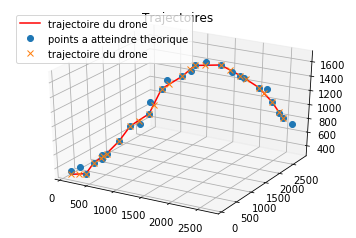

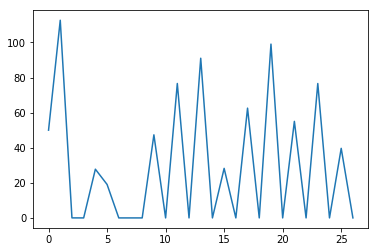

('erreur moyen', 29.09259073528103)
('erreur max', 112.63571586696136)


In [18]:

X1=[100,200,250]
Y1=[100,200,300]
Z1=[350,400,280]


for i in range(15):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] + int(random.uniform(0,200))]
for i in range(10):
    X1 += [X1[-1] + int(random.uniform(0,200))]
    Y1 += [Y1[-1] + int(random.uniform(0,200))]
    Z1 += [Z1[-1] - int(random.uniform(0,200))]




monDrone = Drone()
monDrone.takeoff()
pas=200

for i in range(len(X1)):
    monDrone.goToPoint1([X1[i], Y1[i], Z1[i]], pas)
    
X = monDrone.positionX
Y = monDrone.positionY
Z = monDrone.positionZ

X, erreurs = alignerEchantillon([X1, Y1, Z1], [X, Y, Z])
print(len(X[0])-len(X1))
tracerTrajectoire(X[0], X[1],X[2], X1, Y1, Z1)
plt.plot(erreurs)
plt.show()

print("erreur moyen", sum(erreurs)/len(erreurs))
print("erreur max", max(erreurs))



#### Test 2

doing leftDown
('duration', 0.05)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontRightUp
('duration', 0.0334)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontRightUp
('duration', 0.0141)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackRightUp
('duration', 0.0117)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackRightUp
('duration', 0.0302)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackLeftUp
('duration', 0.0317)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackLeftUp
('duration', 0.0162)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontLeftUp
('duration', 0.0069)
skipping point
skipping point
skipping point
skipping point
ski

('duration', 0.0081)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackLeftUp
('duration', 0.0043)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontLeftUp
('duration', 0.002)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontLeftUp
('duration', 0.0076)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontRightUp
('duration', 0.0092)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing frontRightUp
('duration', 0.0057)
skipping point
skipping point
skipping point
skipping point
skipping point
doing rightUp
('duration', 0.0097)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing BackRightUp
('duration', 0.0087)
skipping point
skipping point
skipping point
skipping point
skipping point
going to point
doing

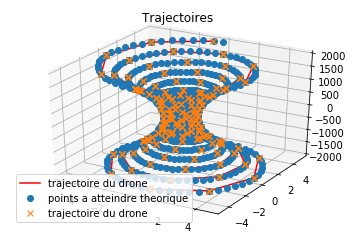

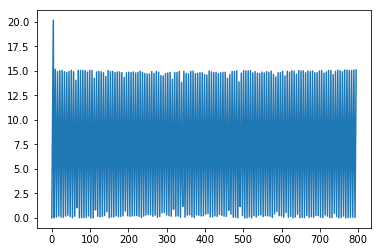

('erreur moyen', 7.5391067285264217)
('erreur max', 20.176948090615802)


In [26]:
from numpy import *

theta=linspace(-16*pi,16*pi,800) 
z=linspace(-2,2,800)
r=z*z+1
x=r*sin(theta)
y=r*cos(theta)

z=z*1000

X1=x.tolist()
Y1=y.tolist()
Z1=z.tolist()


monDrone = Drone()
monDrone.takeoff()
pas=30

for i in range(len(X1)):
    monDrone.goToPoint1([X1[i], Y1[i], Z1[i]], pas)
monDrone.land()

X = monDrone.goneToX
Y = monDrone.goneToY
Z = monDrone.goneToZ


X, erreurs = alignerEchantillon([X1, Y1, Z1], [X, Y, Z])
print(len(X[0])-len(X1))
tracerTrajectoire(X[0], X[1],X[2], X1, Y1, Z1)
plt.plot(erreurs)
plt.show()

print("erreur moyenne", sum(erreurs)/len(erreurs))
print("erreur max", max(erreurs))






#### Fichier executable pour le drone

In [ ]:
#generation du fichier nodeJs pour le drone

suitecommandes="var arDrone = require('ar-drone');\nvar client  = arDrone.createClient();\n \n client.takeoff(); \n "
suitecommandes+=planning

fichierVol = open("fichierVol.js", "w")
fichierVol.write(suitecommandes)
fichierVol.close()

On obtient un fichier de cette forme

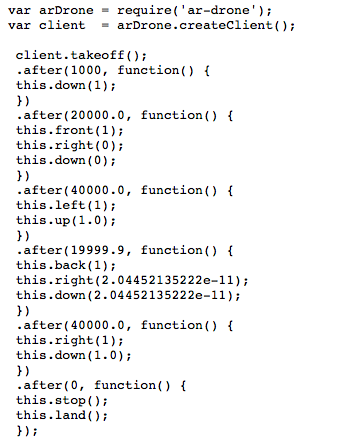